In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import opendatasets as od
import numpy as np
import pandas as pd
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import string
import time
import re

import nltk
from nltk.corpus import stopwords
import plotly.express as px

from natasha import (
    Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger,
    NewsSyntaxParser, NewsNERTagger, PER, NamesExtractor,
    DatesExtractor, MoneyExtractor, AddrExtractor, Doc,
)

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# <hr><p align='center' style='color: #6c89c6;'>Работу выполнил: Таратин Артём ПМ22-1<br> Датасет: [Russian Social Media Text Classification](https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification)</p>

## <hr>**Глава 1. Основа**

### 1.1 Введение в NLP и классификацию текстов

### 1.2 Методы векторизации текста

### 1.3 Описание используемых библиотек

## <hr>**Глава 2. Работа с датасетом**

### 2.1 Описание Датасета

##### **Оригинал:**
VKontakte communities can belong to one of several predefined categories. But even among the sports communities there is a fairly strong division by subject! The same authors can write about only one sport or at once about a large number. Based on a given set of posts, determine the topic – what kind of sport is being discussed in the selected community?

##### **Перевод:**
Сообщества ВКонтакте могут относиться к одной из нескольких предопределенных категорий. Но даже среди спортивных сообществ существует довольно строгое разделение по тематике! Одни и те же авторы могут писать только об одном виде спорта или сразу о большом количестве. Основываясь на заданном наборе постов, определите тему – какой вид спорта обсуждается в выбранном сообществе?

##### **Список доступных категорий (13):**
* athletics – легкая атлетика,
* autosport – автоспорт,
* basketball – баскетбол,
* boardgames – настольные игры,
* esport – киберспорт,
* extreme – экстрим,
* football – футбол,
* hockey – хоккей,
* martial_arts – боевые искусства,
* motosport – автоспорт,
* tennis – теннис,
* volleyball – волейбол,
* winter_sport – зимний спорт

##### **Функция потерь выглядит так:**
```python
def score(true, pred, n_samples):
    counter = 0
    if true == pred:
        counter += 1
    else:
        counter -= 1
    return counter / n_samples
```

#### 2.2 Анализ, Предобработка данных и вывод основных характеристик

Загружаем датасет с kaggle.com

In [3]:
od.download('https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification')

Skipping, found downloaded files in "./russian-social-media-text-classification" (use force=True to force download)


Считываем данные и выводим первые 5 строк

In [4]:
train_data = pd.read_csv('./russian-social-media-text-classification/train.csv')
test_data = pd.read_csv('./russian-social-media-text-classification/test.csv')
train_data.head()

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [5]:
train_data.shape, train_data.category.unique().size

((38740, 3), 13)

In [6]:
train_data.category.unique()

array(['winter_sport', 'extreme', 'football', 'boardgames', 'hockey',
       'esport', 'athletics', 'motosport', 'basketball', 'tennis',
       'autosport', 'martial_arts', 'volleyball'], dtype=object)

In [7]:
train_data.dtypes

oid          int64
category    object
text        object
dtype: object

In [8]:
train_data.isna().sum()

oid         0
category    0
text        0
dtype: int64

Ненужных столбцов нету, также как и выбросов

In [9]:
train_data.duplicated('text').sum()

2966

Но в то же время присутствуют дубликаты, которые лучше убрать, либо оставить первый

In [10]:
train_data.drop_duplicates('text', inplace=True, keep='first')
train_data.duplicated('text').sum()

0

Используем `LabelEncoder()` для предобразования целевого столбца

In [11]:
le = LabelEncoder()
train_data['category_le'] = le.fit_transform(train_data.category)
train_data.head()

,oid,category,text,category_le
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,5
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,6
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,3
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,7


Теперь выведем распределение классов и укажем количество их использований

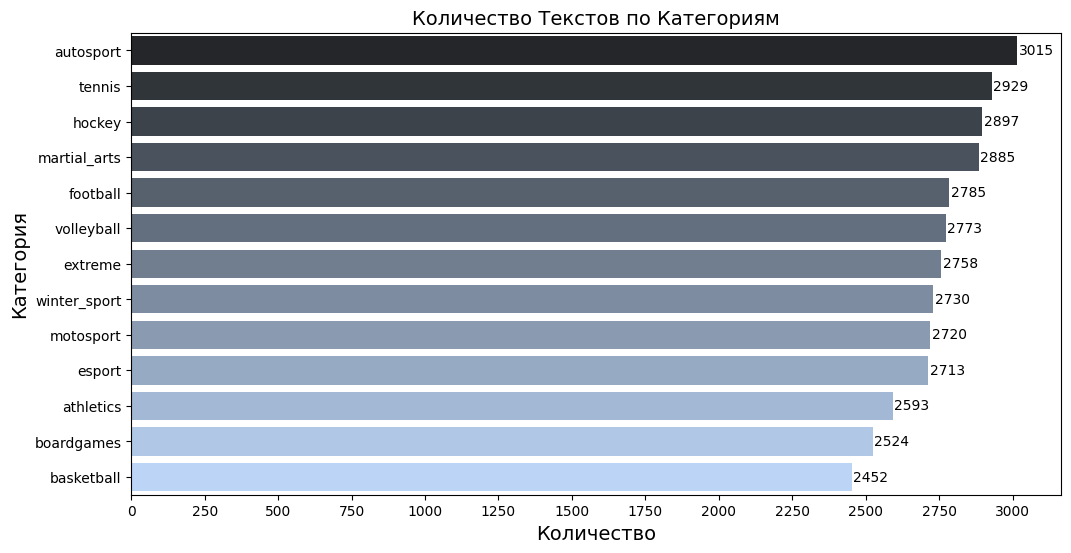

In [12]:
plt.figure(figsize=(12, 6))

sr = train_data.category.value_counts()
xp, yp = np.array(sr), np.array(sr.index)

ax = sns.barplot(x=xp, y=yp, hue=yp, orient='h', color='#b3d4ff', palette='dark:#b3d4ff')
for i, (value, category) in enumerate(zip(xp, yp)):
    ax.text(value+5, i, f'{value}', va='center')  

ax.set_xlabel('Количество', fontsize=14)
ax.set_ylabel('Категория', fontsize=14)
ax.set_title('Количество Текстов по Категориям', fontsize=14)
ax.set_xticks(np.arange(0, 3001, 250))

plt.show()

Построим гистограмму распределения количества символов в предложениях

In [13]:
train_data['length'] = train_data['text'].str.len()
train_data.head(3)

,oid,category,text,category_le,length
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12,65
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,5,246
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,6,704


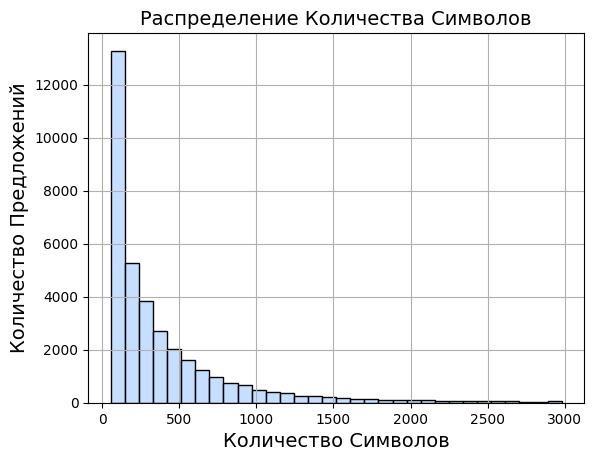

In [14]:
sns.histplot(data=train_data, x='length', bins=32, color='#b3d4ff')
plt.grid(True)
plt.title('Распределение Количества Символов', fontsize=14)
plt.xlabel('Количество Символов', fontsize=14)
plt.ylabel('Количество Предложений', fontsize=14)
plt.show()

Как мы видим, распределение категорий довольно близко к равномерному. В таком случае можно использовать метрику `accuracy_score()` т.к. даже при выборе самого популярного класса точность будет достаточно низкой. Также не стоит забывать про метрику `score()`, предложенную создателями датасета. В любом случае, по своему механизму работы она похожа на `accuracy_score()`, так что мы ничего не теряем. Теперь посмотрим на самые популярные и менее популярные слова в текстах.

In [15]:
word_list = re.findall(r'\b\w{2,}\b', ' '.join(train_data.text.to_numpy()).lower())
df = pd.DataFrame(word_list, columns=['word']).groupby('word').size()
df = df.reset_index(name='count').sort_values('count', ascending=False)
pd.concat([df.head(25).reset_index(drop=True), df.tail(25).reset_index(drop=True)], axis=1)

,word,count,word,count
0,на,39638,манипулировал,1
1,не,23635,мансабын,1
2,что,19917,мансап,1
3,33,19756,манфорд,1
4,по,14054,манси,1
5,за,11337,мануэля,1
6,это,10827,мануэлю,1
7,для,9919,мануэла,1
8,из,9508,мануальный,1
9,но,9212,мануалы,1


В дополнение ко всему, нужно исключить слова, которые не неут никакой смысловой нагрузки. Для этого используем библиотеку `nltk` и `nltk.corpus.stopwords`.

In [16]:
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')
russian_stopwords.extend(np.arange(0, 100).astype(str))  # исключим числа
russian_stopwords.extend(['00', '000', 'tokentokenoid', 'rtokenoid', 'tokenoid', 'tokenoidtokenoid', 'votokenoid'])
russian_stopwords[:10], len(russian_stopwords)

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со'], 258)

In [17]:
fig = px.treemap(df[~df.word.isin(russian_stopwords)].head(275), path=['word'], values='count')
fig.show()

Одними из самых популярных слов оказались предлоги, они не влияют на качество классификации, так как присутствуют в большинстве классов. Они являются шумом, и их можно удалить.

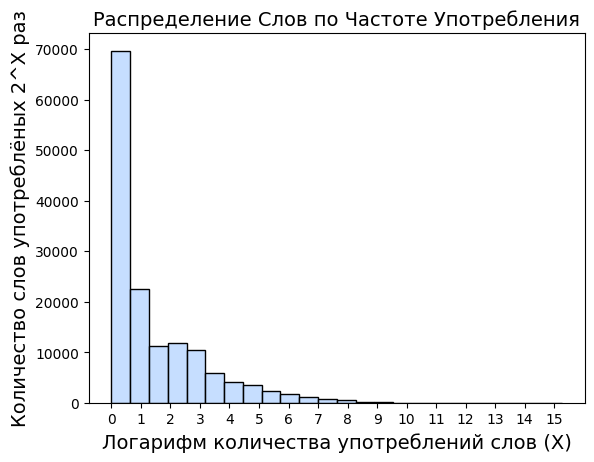

In [18]:
sns.histplot(x=np.log2(df['count']), bins=24, color='#b3d4ff')
plt.xticks(np.arange(0, 16, 1))

plt.title('Распределение Слов по Частоте Употребления', fontsize=14)
plt.xlabel('Логарифм количества употреблений слов (X)', fontsize=14)
plt.ylabel('Количество слов употреблёных 2^X раз', fontsize=14)
plt.grid(True, which='minor')

plt.show()

Большинство слов используются всего 1-4 раз.

Теперь посмотрим на распределение количества символов для каждого класса

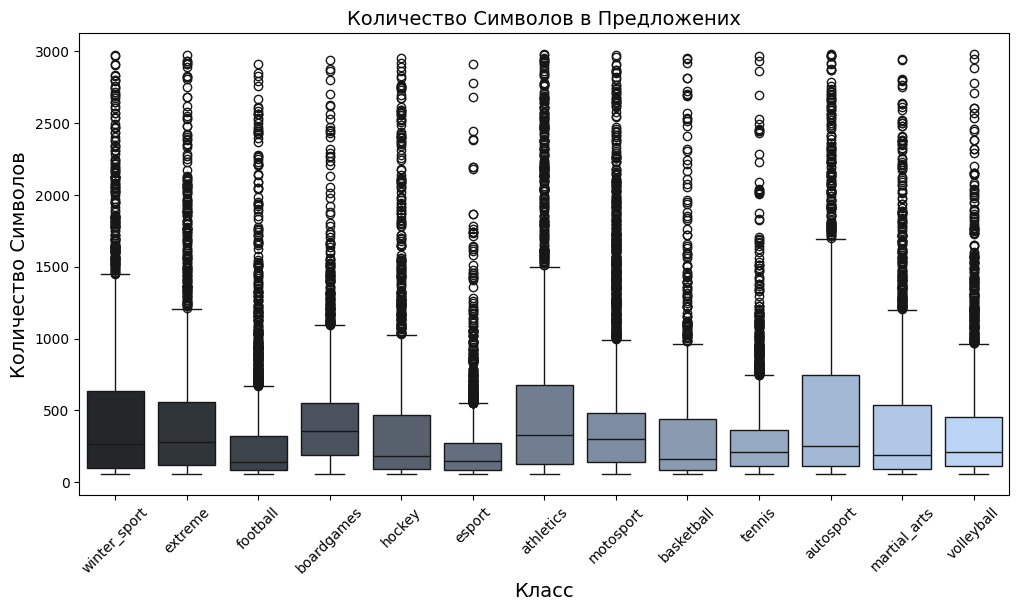

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_data, x='category', y='length', hue='category', color='#b3d4ff', palette='dark:#b3d4ff')

plt.title('Количество Символов в Предложених', fontsize=14)
plt.xlabel('Класс', fontsize=14)
plt.ylabel('Количество Символов', fontsize=14)
plt.xticks(rotation=45)

plt.show()

In [21]:
russian_stopwords = stopwords.words('russian')
russian_stopwords.extend(['tokentokenoid', 'rtokenoid', 'tokenoid', 'tokenoidtokenoid', 'votokenoid'])
russian_stopwords[:10], len(russian_stopwords)

(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со'], 156)

In [20]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [22]:
def tokenize(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    
    punct = string.punctuation
    tokens = [
        i.lemma for i in doc.tokens
        if i.lemma not in punct and
        i.lemma not in russian_stopwords and
        not i.lemma.isnumeric()
    ]

    return tokens

In [23]:
train_data['text_tokenized'] = [tokenize(i) for i in tqdm(train_data.text)]
test_data['text_tokenized'] = [tokenize(i) for i in tqdm(test_data.text)]

100%|██████████| 26260/26260 [07:00<00:00, 62.41it/s] 


Поделим данные на тренировочную, валидационную и тестовую выборки.

In [24]:
X, y = train_data.text_tokenized.to_numpy(), train_data.category_le.to_numpy()
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val)
del X_test_val, y_test_val  # удалим эти переменные, чтобы их после случайно не использовать

Для векторизации текстов и оценки важности слова в контексте документа я буду использовать статистическую меру `tf-idf`. Для оптимизации работы я не буду напрямую векторизировать признаки, вместо этого я использую `Pipeline()` для построения пайплана обучения модели и последующего его обучения.

In [25]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
    ('model', LogisticRegression(n_jobs=-1, random_state=42)),
])

In [26]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
    ('model', MultinomialNB()),
])

In [27]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
    ('model', SGDClassifier(n_jobs=-1, random_state=42)),
])

In [28]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=42)),
])

In [29]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
    ('model', ExtraTreesClassifier(n_jobs=-1, random_state=42)),
])

In [30]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
    ('model', KNeighborsClassifier(n_jobs=-1)),
])

In [31]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
    ('model', GradientBoostingClassifier(random_state=42)),
])

In [32]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
    ('model', SVC(kernel='sigmoid', random_state=42)),
])

In [33]:
# %time
# model.fit(X_train, y_train)
# y_pred = model.predict(X_val)
# score = accuracy_score(y_pred, y_val)
# print(score)

In [34]:
models = [
    LogisticRegression(n_jobs=-1, random_state=42),
    MultinomialNB(),
    SGDClassifier(n_jobs=-1, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42),
    ExtraTreesClassifier(n_jobs=-1, random_state=42),
    KNeighborsClassifier(n_jobs=-1),
    GradientBoostingClassifier(random_state=42),
    SVC(kernel='linear'),
]

In [35]:
%time
print(' ' + '_'*49)
all_models_scores = []
for model in models:
        model_name = model.__class__.__name__
        print(f'| Модель {model_name:<40} |')
        start_time = time.time()
        model = Pipeline([
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
                ('model', model),
        ])
        model.fit(X_train, y_train)
        end_time = time.time()
        learning_time = end_time - start_time

        y_pred = model.predict(X_val)
        score = accuracy_score(y_pred, y_val)
        print(f'|   {score=:.4f} {learning_time=:<18.4f} |', end=f'\n {'_'*49}\n')

        all_models_scores.append({'name': model_name, 'score': score, 'time': learning_time})

CPU times: user 2 µs, sys: 4 µs, total: 6 µs
Wall time: 7.15 µs
 _________________________________________________
| Модель LogisticRegression                       |
|   score=0.8437 learning_time=5.0337             |
 _________________________________________________
| Модель MultinomialNB                            |
|   score=0.8328 learning_time=0.3213             |
 _________________________________________________
| Модель SGDClassifier                            |
|   score=0.8657 learning_time=0.3558             |
 _________________________________________________
| Модель RandomForestClassifier                   |
|   score=0.7957 learning_time=5.4642             |
 _________________________________________________
| Модель ExtraTreesClassifier                     |
|   score=0.8274 learning_time=7.4452             |
 _________________________________________________
| Модель KNeighborsClassifier                     |
|   score=0.7979 learning_time=0.3064             |
 _____

In [36]:
models_df = pd.DataFrame(all_models_scores)
models_df = models_df.sort_values('score', ascending=False).reset_index(drop=True)
models_df

,name,score,time
0,SGDClassifier,0.865688,0.355774
1,SVC,0.844864,57.216298
2,LogisticRegression,0.843746,5.033742
3,MultinomialNB,0.832844,0.321273
4,ExtraTreesClassifier,0.827393,7.445234
5,KNeighborsClassifier,0.797904,0.306425
6,RandomForestClassifier,0.795667,5.464211
7,GradientBoostingClassifier,0.773725,196.294629


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# MultinomialNB, ComplementNB,
model = Pipeline([
        ('tfidf', TfidfVectorizer(max_df=0.4, stop_words=russian_stopwords)),
        ('model', ComplementNB(alpha=0.25)),
])
model.fit(X_train.tolist(), y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.4,
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...])),
                ('model', ComplementNB(alpha=0.25))])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = model.predict(X_train)
accuracy_score(y_pred, y_train), f1_score(y_pred, y_train, average='macro')

(0.9854174431606411, 0.9855065471668621)

In [ ]:
y_pred = model.predict(X_val)
accuracy_score(y_pred, y_val), f1_score(y_pred, y_val, average='macro')

(0.8630328441649197, 0.8625475760087511)

In [ ]:
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test), f1_score(y_pred, y_test, average='macro')

(0.8698812019566736, 0.8691102539115131)

In [ ]:
print(classification_report(y_pred, y_test, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       561
           1       0.89      0.89      0.89       604
           2       0.90      0.92      0.91       478
           3       0.97      0.82      0.89       597
           4       0.80      0.87      0.83       501
           5       0.74      0.76      0.75       532
           6       0.80      0.89      0.84       497
           7       0.88      0.87      0.87       585
           8       0.80      0.89      0.84       518
           9       0.90      0.88      0.89       558
          10       0.97      0.92      0.95       619
          11       0.89      0.88      0.88       561
          12       0.89      0.89      0.89       544

    accuracy                           0.87      7155
   macro avg       0.87      0.87      0.87      7155
weighted avg       0.87      0.87      0.87      7155



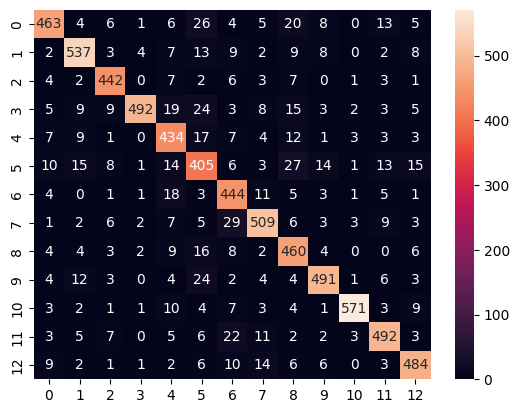

In [ ]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='.0f')
plt.show()

In [ ]:
# evaluate metric look like
def score(true, pred, n_samples):
    counter = 0
    if true == pred:
        counter += 1
    else:
        counter -= 1
    return counter / n_samples

In [ ]:
y_pred = model.predict(X_test)
sum([score(it, ip, len(y_test)) for it, ip in zip(y_test, y_pred)])

0.7397624039133472